In [1]:
from re import L
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import torch
import os
from models.custom_models import custom_models
from torchvision import transforms
import torchvision
import scipy
import pickle
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import argparse
from sklearn.mixture import GaussianMixture
from CIRF_modules import trainer
from CIRF_modules import finder
import pickle
from tqdm import tqdm
import PIL
import torch.backends.cudnn as cudnn
import random

from models.styleswin.styleswin_generator import Generator
from models.styleswin.styleswin_discriminator import Discriminator
from models.styleswin import stylegan_encoder_network


To run facial dataset, the pre-trained StyleSwin should be downloaded.

You can access it through https://github.com/microsoft/StyleSwin.

Then, the CelebAHQ_256.pt file should be located in "models/pretrain/"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = argparse.Namespace(
    path = 'celebA_250_1030',
    peak_ratio = 0.5, # confidence of label in latent codes
    normal_method = 'mode',
    mode_ratio = 1,
    sub_weight = 0.1,
    GMM_component = 5,
    seed = 2,
    device = 0,
    multi_gpu = True,
    w_shift = True,
    k_count = 25, # the number of directions
    shift_distribution_key = 'normal', # distribution of eps
    lr = 1e-2, 
    elastic_coef = 1e-2,
    batch_size = 3, # training batch
    min_shift = 0.0001, # minumum magnitude of eps
    shift_scale = 5.0, # magnitude of eps
    label_weight = 1.0, # coef of loss function
    shift_weight = 0.25, # coef of loss function
    n_latent = 14, # w dim
    eps_distribution = 'none', # distribution of eps
    latent_dim = 512, # generator's latent
    num_steps = 100, # training steps
    num_classes = 4, # the number of classes
    save_path = './models/pretrain/test/',
    input_latent_path = './data/latent_g_input_saved/incorrect_latent_torch/',
    latent_iteration = 300, # the number of generating random latent
    random_latent_std = 1, # std of random latent
    latent_batch = 40, # the number of generating random latent batch
    latent_type = 'random', # 'random' or 'training' : type of latent codes
    classifier_path = './models/pretrain/CelebA_HQ_resnet18_from_scratch_hair_4classes.pth', # classifier path
    embedder_path = './models/pretrain/celebA_hair5_w_compete_normal.pt', # projector(embedder) path
    tensorboard_path = './results/celebA/tb_results_hair5_gmmcenter_w_normal',
    w_traindata_path = './data/CelebA-HQ/refined_latent_dict',
    modifying_trial = 15,
    top_center = False,
    tuned_gamma = True,
    use_transform = False,
    use_calibration = False,
    use_perturbing = True,
    w_space = True,
    class_range = None,
)

args.w_traindata_path = './data/CelebA-HQ/refined_latent_dict_' + args.path + '.pth'
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)
debug_mode = True


In [3]:

# model load

classifier = torchvision.models.resnet18(pretrained=False).to(device)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, args.num_classes)
classifier.to(device)
generator = Generator(
        256, 512, 8, channel_multiplier=2, lr_mlp=0.01,
        enable_full_resolution=8
    ).to(device)
ckpt = torch.load('./models/pretrain/CelebAHQ_256.pt', map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"])

classifier_state_dict = torch.load(args.classifier_path)
classifier.load_state_dict(classifier_state_dict)

classifier.eval()
generator.eval()

transform = transforms.Compose([
                                # transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


tensor_to_pil_transform = transforms.Compose([
                                transforms.ToPILImage()
])


In [4]:
# for generated data test
num_samples = 250
batch_for_samples = 5
sample_z = torch.load(f'./data/CelebA-HQ/sample_latents_{num_samples}/latents.pt')

total_tensor = []
sample_latent = []
for i in range(int(num_samples / batch_for_samples)):
    with torch.no_grad():
        generated_images, generated_w = generator(sample_z[i * batch_for_samples : (i+1) * batch_for_samples])
        total_tensor.append(generated_images)
        sample_latent.append(generated_w)
sample_w = torch.cat(sample_latent)


In [5]:
trainer = trainer.FinderTrainer(classifier, generator, args, tuned_gamma=args.tuned_gamma, use_transform=args.use_transform)
torch.save(trainer.refined_latent_dict, args.w_traindata_path)

center of target maker: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


In [6]:
label_dict = {0:'Black_Hair', 1:'Blond_Hair', 2:'Brown_Hair'}
loaded_sample_images = torch.cat(total_tensor).detach().cpu()
save_distances = pd.DataFrame()
start_iter = 150
end_iter = 153

  0%|          | 0/3 [00:00<?, ?it/s]

iteration: 150


total_loss:0.4060, cf:0.0000, direction_norm:3836.1719, 50.0693: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]
direction_maker:   6%|▌         | 6/101 [00:00<00:10,  9.05it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


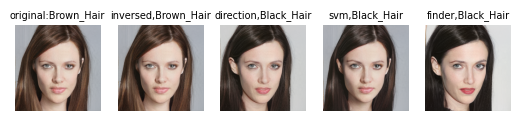

total_loss:0.3992, cf:0.0000, direction_norm:3791.6348, 48.9872: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]
direction_maker:   5%|▍         | 5/101 [00:00<00:09,  9.63it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


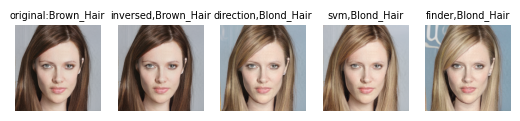

total_loss:0.5167, cf:0.1164, direction_norm:3691.2153, 51.8006: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]
direction_maker:  13%|█▎        | 13/101 [00:01<00:09,  9.28it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


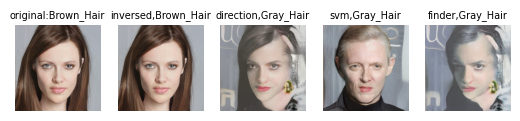

 33%|███▎      | 1/3 [02:20<04:40, 140.40s/it]

iteration: 151


total_loss:0.4125, cf:0.0000, direction_norm:3912.2319, 50.4208: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]
direction_maker:   5%|▍         | 5/101 [00:00<00:10,  9.17it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


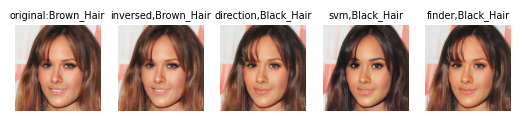

total_loss:0.4078, cf:0.0000, direction_norm:3877.6362, 49.7412: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]
direction_maker:   4%|▍         | 4/101 [00:00<00:10,  9.22it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


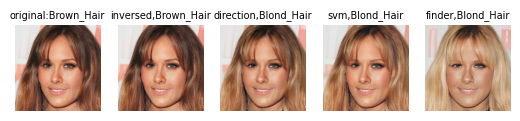

total_loss:7.6957, cf:7.2984, direction_norm:3622.2588, 52.2796: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]
total_loss:2.9884, cf:2.3762, direction_norm:5744.7197, 79.4629: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]
total_loss:1.0531, cf:0.0928, direction_norm:9015.0947, 120.8904: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]
direction_maker:  12%|█▏        | 12/101 [00:01<00:09,  9.18it/s]


svm


modifying trial:   0%|          | 0/15 [00:05<?, ?it/s]


success. founded at positive point
finder


modifying trial:  60%|██████    | 9/15 [00:52<00:34,  5.79s/it]

success. founded at negative point


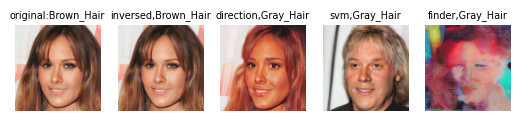

 67%|██████▋   | 2/3 [05:14<02:30, 150.44s/it]

iteration: 152


total_loss:0.4124, cf:0.0000, direction_norm:3913.1572, 50.3520: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]
direction_maker:   7%|▋         | 7/101 [00:00<00:10,  9.08it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


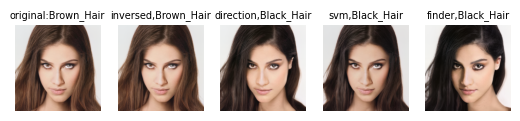

total_loss:0.3965, cf:0.0001, direction_norm:3757.7671, 48.7175: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]
direction_maker:   7%|▋         | 7/101 [00:00<00:09,  9.53it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


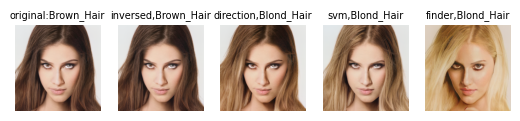

total_loss:8.1888, cf:7.7766, direction_norm:3771.5703, 54.2042: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]
total_loss:0.7419, cf:0.0572, direction_norm:6446.8682, 87.2554: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]
direction_maker:  11%|█         | 11/101 [00:01<00:09,  9.68it/s]


svm


modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

success. founded at positive point
finder
sucess. found at PP


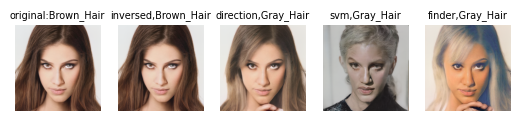

100%|██████████| 3/3 [07:03<00:00, 141.25s/it]


In [8]:
pbar = tqdm(range(start_iter, end_iter))
for iteration in pbar:
    print(f'iteration: {iteration}')
    original_image = (loaded_sample_images[iteration].unsqueeze(0)).to(device)

    z = sample_w[iteration]
    with torch.no_grad():
        original_logits  = classifier(original_image.to(device))
    original_class = int(torch.argmax(original_logits, 1))
    
    for counterclass in range(len(label_dict)):
        target_class = counterclass
        if target_class == original_class:
            continue
        args.class_range = f'{original_class}-{target_class}'
        direction_vector, loss_list = trainer.train_celebA_w_one(input_latent=z.unsqueeze(0), original_class=original_class, target_class=target_class, latent_shape=torch.zeros([args.latent_dim]).shape , debug_mode=debug_mode, save=False, tuned_gamma=True)
        direction_vector_norm = (direction_vector / torch.linalg.norm(direction_vector[0][0])).squeeze()
        

        if iteration==start_iter:
            finder_maker = finder.FinderMaker_ImageNet_Plausible(projector=None, classifier=classifier, generator=generator, transforms=transform, args=args, gmms=trainer.gmms, center_of_target=trainer.center_of_target, SVM_coefs=None) 
            SVM_coefs = finder_maker.SVM_coefs
        else:
            finder_maker = finder.FinderMaker_ImageNet_Plausible(projector=None, classifier=classifier, generator=generator, transforms=transform, args=args, gmms=trainer.gmms, center_of_target=trainer.center_of_target, SVM_coefs=SVM_coefs) 

        # finder_maker = finder.FinderMaker_ImageNet_Plausible(projector=None, classifier=classifier, generator=generator, transforms=transform, args=args, gmms=trainer.gmms, center_of_target=trainer.center_of_target) 
        
        z_direction, z_semifactual = finder_maker.direction_maker(z, original_class, target_class, coef_name='one', direction=direction_vector_norm)#, target_range=class_label_dict)
        z_svm = finder_maker.SVM_maker(z, original_class, target_class)#, target_range=class_label_dict)
        z_finder = finder_maker.finder_maker_one(z, original_class, target_class, direction=direction_vector_norm, mode='one')#, target_range=class_label_dict)

        z_list = {'inversed':z.unsqueeze(0).float(),
                'direction': z_direction.unsqueeze(0).float(), 
                'svm': z_svm.float(),
                'finder': z_finder.float()}
   
        with torch.no_grad():
            images = {}
            preds = {}
            logits = classifier(original_image)
            original_image_save = torchvision.utils.make_grid(invTrans(original_image), normalize=True).detach().cpu()
            # if debug_mode == True:
            #     pred = int(torch.argmax(logits))
            #     plt.imshow(original_image_save.permute(1,2,0))
            #     plt.title(f'original_class:{label_dict[pred]}')
            #     plt.show()
            for method in z_list.keys():
                with torch.no_grad():
                    images[method] = generator(latent=z_list[method])[0]
                    logits = classifier(images[method])
                preds[method] = int(torch.argmax(logits))
                save_image = torchvision.utils.make_grid(invTrans(images[method]), normalize=True).detach().cpu()
                # if debug_mode == True:
                #     plt.imshow(save_image.permute(1,2,0))
                #     plt.title(f'{method}_class:{label_dict[preds[method]]}')
                #     plt.show()

        f, axarr = plt.subplots(1, len(z_list) + 1)
        axarr[0].imshow(original_image_save.permute(1,2,0))
        axarr[0].title.set_text(f'original:{label_dict[original_class].split(",")[0]}')
        axarr[0].title.set_fontsize(7)
        axarr[0].axis('off')
        for ax_i, method in enumerate(z_list.keys(), start=1):
            normed_image = images[method].squeeze().detach().cpu()
            save_image = torchvision.utils.make_grid(invTrans(normed_image), normalize=True).detach().cpu()
            axarr[ax_i].imshow(save_image.permute(1,2,0))
            axarr[ax_i].axis('off')
            axarr[ax_i].title.set_text(f'{method},{label_dict[preds[method]].split(",")[0]}')
            axarr[ax_i].title.set_fontsize(7)
            
        plt.show()